In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
%config InlineBackend.print_figure_kwargs = {'bbox_inches': None}

In [3]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [4]:
grid_files = ["/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc", 
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc",
              "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_zgr.nc"]

In [5]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)

## snapshot

In [52]:
f_ice_REF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08/2001/CREG12.L75-REF08_y2001m09d13.5d_icemod.nc"
f_KE_REF = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-KE/2001/CREG12.L75-REF08_y2001m09d13.5d_KE.nc"

In [53]:
f_ice_FUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08/2051/CREG12.L75-FUT08_y2051m09d12.5d_icemod.nc"
f_KE_FUT = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-KE/2051/CREG12.L75-FUT08_y2051m09d12.5d_KE.nc"

In [54]:
ice_REF = xr.open_mfdataset(f_ice_REF, parallel=True, preprocess=prepro)
KE_REF = xr.open_mfdataset(f_KE_REF, parallel=True, preprocess=prepro)

In [55]:
ice_FUT = xr.open_mfdataset(f_ice_FUT, parallel=True, preprocess=prepro)
KE_FUT = xr.open_mfdataset(f_KE_FUT, parallel=True, preprocess=prepro)

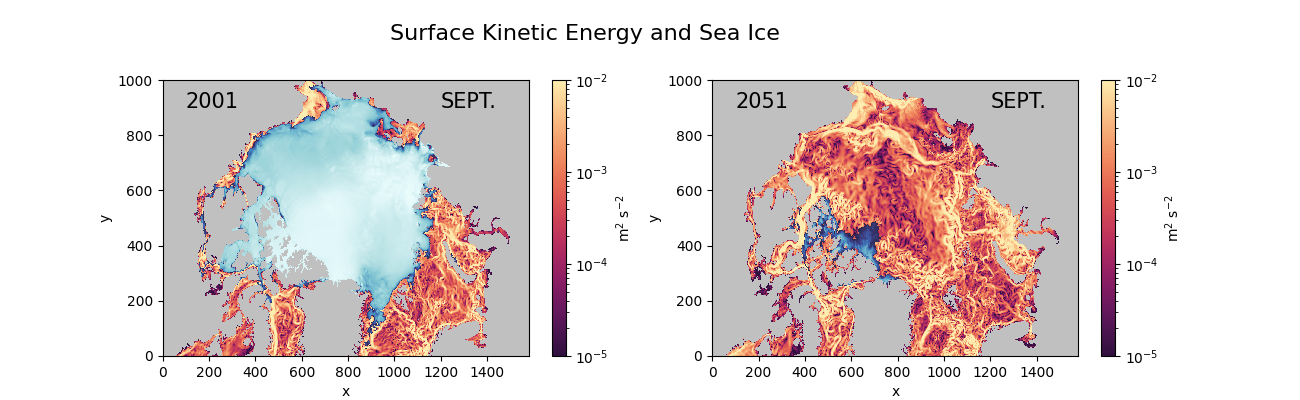

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].set_facecolor("silver")
a = ax[0].pcolormesh(KE_REF.x, KE_REF.y, KE_REF.voke.isel(deptht=0).squeeze(), 
                    cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                    shading="nearest", zorder=1)
plt.colorbar(a, ax=ax[0], label=r"m$^{2}$ s$^{-2}$")
ax[0].pcolormesh(ice_REF.x, ice_REF.y, ice_REF.siconc.where(ice_REF.siconc>0.15).squeeze(), 
                 vmin=0, vmax=1, cmap=cmo.ice, shading="nearest", zorder=2)
ax[0].text(100, 900, "2001", fontsize=15)
ax[0].text(1200, 900, "SEPT.", fontsize=15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].set_facecolor("silver")
b = ax[1].pcolormesh(KE_FUT.x, KE_FUT.y, KE_FUT.voke.isel(deptht=0).squeeze(), 
                    cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                    shading="nearest", zorder=1)
plt.colorbar(b, ax=ax[1], label=r"m$^{2}$ s$^{-2}$")
ax[1].pcolormesh(ice_FUT.x, ice_FUT.y, ice_FUT.siconc.where(ice_FUT.siconc>0.15).squeeze(), 
                 vmin=0, vmax=1, cmap=cmo.ice, shading="nearest", zorder=2)
ax[1].text(100, 900, "2051", fontsize=15)
ax[1].text(1200, 900, "SEPT.", fontsize=15)
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

fig.text(0.3, 0.9, "Surface Kinetic Energy and Sea Ice", fontsize=16);

plt.subplots_adjust(top=0.8)

#plt.savefig("/home/rieck/figures/CREG12.L75_2001vs2051_KE_sea_ice_september.png", dpi=300)

## means

In [6]:
KE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-KE" 
                                + "/clim/CREG12.L75-REF08_*.5d_KEclim.nc"))
KE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-KE" 
                                + "/clim/CREG12.L75-FUT08_*.5d_KEclim.nc"))
MKE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-MKE" 
                                + "/clim/CREG12.L75-REF08_*.5d_MKE.nc"))
MKE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-MKE" 
                                + "/clim/CREG12.L75-FUT08_*.5d_MKE.nc"))
EKE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-EKE" 
                                + "/clim/CREG12.L75-REF08_*.5d_EKEclim.nc"))
EKE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-EKE" 
                                + "/clim/CREG12.L75-FUT08_*.5d_EKEclim.nc"))
ICE_data_filesREF = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-icemod_clim/" 
                                + "/CREG12.L75-REF08_*.5d_icemodclim.nc"))
ICE_data_filesFUT = sorted(glob("/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-icemod_clim/" 
                                + "/CREG12.L75-FUT08_*.5d_icemodclim.nc"))

In [7]:
KEREF = xr.open_mfdataset(KE_data_filesREF, parallel=True, preprocess=prepro)
KEFUT = xr.open_mfdataset(KE_data_filesFUT, parallel=True, preprocess=prepro)
MKEREF = xr.open_mfdataset(MKE_data_filesREF, parallel=True, preprocess=prepro)
MKEFUT = xr.open_mfdataset(MKE_data_filesFUT, parallel=True, preprocess=prepro)
EKEREF = xr.open_mfdataset(EKE_data_filesREF, parallel=True, preprocess=prepro)
EKEFUT = xr.open_mfdataset(EKE_data_filesFUT, parallel=True, preprocess=prepro)
ICEREF = xr.open_mfdataset(ICE_data_filesREF, parallel=True, preprocess=prepro)
ICEFUT = xr.open_mfdataset(ICE_data_filesFUT, parallel=True, preprocess=prepro)

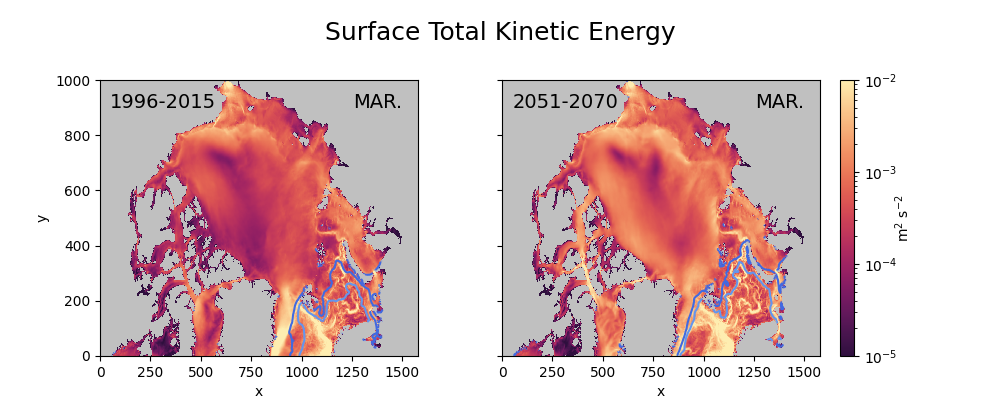

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_facecolor("silver")
a = ax[0].pcolormesh(KEREF.x, KEREF.y, 
                     KEREF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=0, month=2).squeeze(), 
                     cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                     shading="nearest", zorder=1)
plt.colorbar(a, ax=ax[0], label=r"m$^{2}$ s$^{-2}$")
ax[0].contour(ICEREF.x, ICEREF.y, 
              ICEREF.siconc.groupby("time_counter.month").mean("time_counter").isel(month=2).squeeze(), 
              levels=[0.15, 0.8], colors=["cornflowerblue", "royalblue"], zorder=2)
ax[0].text(50, 900, "1996-2015", fontsize=14)
ax[0].text(1500, 900, "MAR.", fontsize=14, ha="right")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].set_facecolor("silver")
b = ax[1].pcolormesh(KEFUT.x, KEFUT.y, 
                     KEFUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=0, month=2).squeeze(), 
                     cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                     shading="nearest", zorder=1)
cb = plt.colorbar(b, ax=ax[1])
cb.set_label(r"m$^{2}$ s$^{-2}$", labelpad=-3)
ax[1].contour(ICEFUT.x, ICEFUT.y, 
              ICEFUT.siconc.groupby("time_counter.month").mean("time_counter").isel(month=2).squeeze(), 
              levels=[0.15, 0.8], colors=["cornflowerblue", "royalblue"], zorder=2)
ax[1].text(50, 900, "2051-2070", fontsize=14)
ax[1].text(1500, 900, "MAR.", fontsize=14, ha="right")
ax[1].set_xlabel("x")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])

fig.text(0.5, 0.9, "Surface Total Kinetic Energy", fontsize=18, ha="center");

plt.subplots_adjust(top=0.8, wspace=0.01, left=0.1, right=0.9)

fig.delaxes(fig.axes[2])

plt.savefig("/home/rieck/figures/CREG12.L75_REFvsFUT_KE_ice_0000m_march.png", dpi=300)

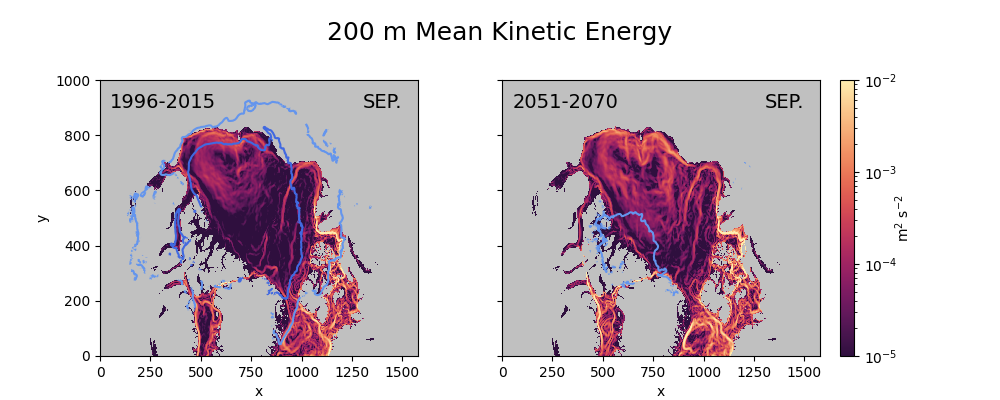

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_facecolor("silver")
a = ax[0].pcolormesh(MKEREF.x, MKEREF.y, 
                     MKEREF.vomke.groupby("time_counter.month").mean("time_counter").isel(deptht=30, month=8).squeeze(), 
                     cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                     shading="nearest", zorder=1)
plt.colorbar(a, ax=ax[0], label=r"m$^{2}$ s$^{-2}$")
ax[0].contour(ICEREF.x, ICEREF.y, 
              ICEREF.siconc.groupby("time_counter.month").mean("time_counter").isel(month=8).squeeze(), 
              levels=[0.15, 0.8], colors=["cornflowerblue", "royalblue"], zorder=2)
ax[0].text(50, 900, "1996-2015", fontsize=14)
ax[0].text(1500, 900, "SEP.", fontsize=14, ha="right")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].set_facecolor("silver")
b = ax[1].pcolormesh(MKEFUT.x, MKEFUT.y, 
                     MKEFUT.vomke.groupby("time_counter.month").mean("time_counter").isel(deptht=30, month=8).squeeze(), 
                     cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                     shading="nearest", zorder=1)
cb = plt.colorbar(b, ax=ax[1])
cb.set_label(r"m$^{2}$ s$^{-2}$", labelpad=-3)
ax[1].contour(ICEFUT.x, ICEFUT.y, 
              ICEFUT.siconc.groupby("time_counter.month").mean("time_counter").isel(month=8).squeeze(), 
              levels=[0.15, 0.8], colors=["cornflowerblue", "royalblue"], zorder=2)
ax[1].text(50, 900, "2051-2070", fontsize=14)
ax[1].text(1500, 900, "SEP.", fontsize=14, ha="right")
ax[1].set_xlabel("x")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])

fig.text(0.5, 0.9, "200 m Mean Kinetic Energy", fontsize=18, ha="center");

plt.subplots_adjust(top=0.8, wspace=0.01, left=0.1, right=0.9)

fig.delaxes(fig.axes[2])

#plt.savefig("/home/rieck/figures/CREG12.L75_REFvsFUT_MKE_ice_0200m_september.png", dpi=300)

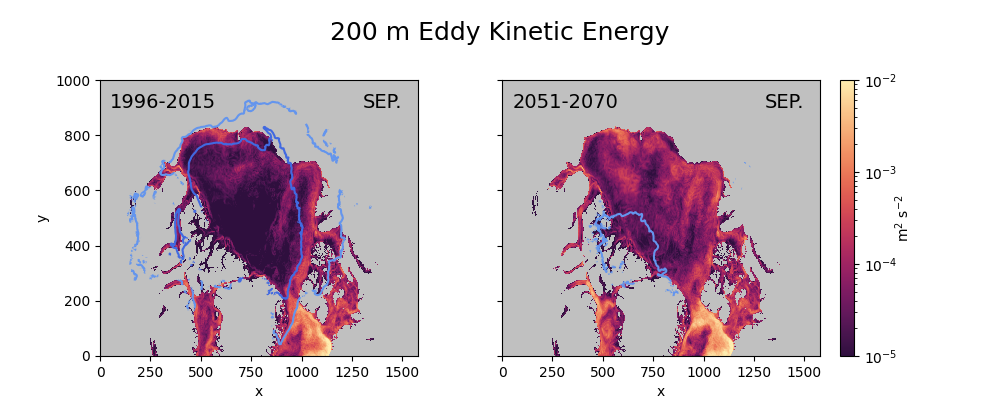

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].set_facecolor("silver")
a = ax[0].pcolormesh(EKEREF.x, EKEREF.y, 
                     EKEREF.voeke.groupby("time_counter.month").mean("time_counter").isel(deptht=30, month=8).squeeze(), 
                     cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                     shading="nearest", zorder=1)
plt.colorbar(a, ax=ax[0], label=r"m$^{2}$ s$^{-2}$")
ax[0].contour(ICEREF.x, ICEREF.y, 
              ICEREF.siconc.groupby("time_counter.month").mean("time_counter").isel(month=8).squeeze(), 
              levels=[0.15, 0.8], colors=["cornflowerblue", "royalblue"], zorder=2)
ax[0].text(50, 900, "1996-2015", fontsize=14)
ax[0].text(1500, 900, "SEP.", fontsize=14, ha="right")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

ax[1].set_facecolor("silver")
b = ax[1].pcolormesh(EKEFUT.x, EKEFUT.y, 
                     EKEFUT.voeke.groupby("time_counter.month").mean("time_counter").isel(deptht=30, month=8).squeeze(), 
                     cmap=cmo.matter_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e-2),
                     shading="nearest", zorder=1)
cb = plt.colorbar(b, ax=ax[1])
cb.set_label(r"m$^{2}$ s$^{-2}$", labelpad=-3)
ax[1].contour(ICEFUT.x, ICEFUT.y, 
              ICEFUT.siconc.groupby("time_counter.month").mean("time_counter").isel(month=8).squeeze(), 
              levels=[0.15, 0.8], colors=["cornflowerblue", "royalblue"], zorder=2)
ax[1].text(50, 900, "2051-2070", fontsize=14)
ax[1].text(1500, 900, "SEP.", fontsize=14, ha="right")
ax[1].set_xlabel("x")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])

fig.text(0.5, 0.9, "200 m Eddy Kinetic Energy", fontsize=18, ha="center");

plt.subplots_adjust(top=0.8, wspace=0.01, left=0.1, right=0.9)

fig.delaxes(fig.axes[2])

#plt.savefig("/home/rieck/figures/CREG12.L75_REFvsFUT_EKE_ice_0200m_september.png", dpi=300)